# Neural Network Models

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import ConvLSTM2D
from keras.utils import to_categorical
from keras import backend as K 
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model, model_from_json
from keras.metrics import CategoricalAccuracy, CategoricalCrossentropy
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, auc, roc_curve, roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, classification_report

from numpy.random import seed
from tensorflow.random import set_seed



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/human-activity-recognition/UCI_HAR_Dataset/activity_labels.txt
/kaggle/input/human-activity-recognition/UCI_HAR_Dataset/README.txt
/kaggle/input/human-activity-recognition/UCI_HAR_Dataset/features_info.txt
/kaggle/input/human-activity-recognition/UCI_HAR_Dataset/features.txt
/kaggle/input/human-activity-recognition/UCI_HAR_Dataset/test/subject_test.txt
/kaggle/input/human-activity-recognition/UCI_HAR_Dataset/test/y_test.txt
/kaggle/input/human-activity-recognition/UCI_HAR_Dataset/test/X_test.txt
/kaggle/input/human-activity-recognition/UCI_HAR_Dataset/test/Inertial Signals/body_acc_y_test.txt
/kaggle/input/human-activity-recognition/UCI_HAR_Dataset/test/Inertial Signals/total_acc_y_test.txt
/kaggle/input/human-activity-recognition/UCI_HAR_Dataset/test/Inertial Signals/total_acc_z_test.txt
/kaggle/input/human-activity-recognition/UCI_HAR_Dataset/test/Inertial Signals/body_acc_z_test.txt
/kaggle/input/human-activity-recognition/UCI_HAR_Dataset/test/Inertial Signals/body_gyr

In [2]:
activities = {
    1: 'Walking',
    2: 'Walking Upstairs',
    3: 'Walking Downstairs',
    4: 'Sitting',
    5: 'Standing',
    6: 'Laying'
}

## Data Pipeline

In [3]:
# load a single file as a numpy array
def load_file(filepath):
    df = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return df.values

# load a list of files into a 3D array of [observations, timesteps, features(x,y,z)]
def load_group(files, prefix=''):
    loaded = list()
    for f in files:
        data = load_file(prefix + f)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    files = list()
    # body acceleration
    files += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    files += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # total acceleration
    files += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # load input data
    X = load_group(files, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

def load_dataset(prefix=''):
    # load all train
    X_train, y_train = load_dataset_group('train', prefix)
    # load all test
    X_test, y_test = load_dataset_group('test', prefix)
    # zero-offset class values
    y_train = y_train - 1
    y_test = y_test - 1
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    print(f"""Dataset loaded.
Training Set:
X_train {X_train.shape} y_train {y_train.shape}
Test Set:
X_test {X_test.shape} y_test {y_test.shape}""")
    return X_train, y_train, X_test, y_test

## Hyperparameters Tuning

In [4]:
def create_model(model):
    classifier = KerasClassifier(model, verbose=2)
    return classifier

In [5]:
# GridSearch
def grid(classifier):
    # define the grid search parameters
    batch_size = [8, 16, 32, 64]
    epochs = [10, 15, 20, 25]
    validation_split=[0.2]
    param_grid = dict(batch_size=batch_size, epochs=epochs, validation_split=validation_split)
    grid = GridSearchCV(estimator=classifier, param_grid=param_grid, n_jobs=-1, cv=5, return_train_score=True, verbose=2)
    grid_result = grid.fit(X_train, y_train)
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    return grid_result

## Evaluate Model

In [6]:
def evaluate_model(X_train, y_train, X_test, y_test, params, model):
    epochs, batch_size = params["epochs"], params["batch_size"]
    es =EarlyStopping(monitor='val_loss', patience=5)
    classifier=model()
    history = classifier.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2, validation_split=0.2, callbacks=[es])
    # evaluate model
    _, accuracy = classifier.evaluate( X_test, y_test, batch_size=batch_size, verbose=0)
    return history, accuracy, classifier

In [7]:
def run_model(model, grid_result):
    history, score, classifier = evaluate_model(X_train, y_train, X_test, y_test, grid_result.best_params_, model)
    score = score * 100.0
    print('> %.3f' % (score))
    results=pd.DataFrame(history.history, index=history.epoch)
    return results, classifier

In [8]:
def plot_loss(results):
    plt.style.use('seaborn-whitegrid')
    sns.set(style="white", font_scale = 1.5)
    fig, axes = plt.subplots(1,2, figsize=(20,10), sharex=True)
    axes[0].set_title('Loss')
    axes[0].plot(results['loss'], label='train', )
    axes[0].plot(results['val_loss'], label='test')
    axes[0].legend()
    #plot accuracy during training
    axes[1].set_title('Accuracy')
    axes[1].plot(results['accuracy'], label='train')
    axes[1].plot(results['val_accuracy'], label='test')
    axes[1].legend()
    plt.show()
    return

In [9]:
def run(model):
    classifier=create_model(model)
    grid_result=grid(classifier)
    results, classifier=run_model(model, grid_result)
    plot_loss(results)
    return classifier

## Base Model

In [10]:
X_train, y_train, X_test, y_test = load_dataset(prefix="../input/human-activity-recognition/UCI_HAR_Dataset/")
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]

Dataset loaded.
Training Set:
X_train (7352, 128, 9) y_train (7352, 6)
Test Set:
X_test (2947, 128, 9) y_test (2947, 6)


### LSTM Model

In [11]:
def model1():
    seed(17)
    set_seed(17)
    K.clear_session()
    model = Sequential()
    model.add(LSTM(64, input_shape=(n_timesteps,n_features)))
    model.add(Dropout(0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
    return model

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  2.3min finished


Epoch 1/10
736/736 - 5s - loss: 0.9594 - accuracy: 0.5819 - val_loss: 0.8237 - val_accuracy: 0.7206
Epoch 2/10
736/736 - 4s - loss: 0.5012 - accuracy: 0.8005 - val_loss: 0.6558 - val_accuracy: 0.7961
Epoch 3/10
736/736 - 4s - loss: 0.2549 - accuracy: 0.9116 - val_loss: 0.5062 - val_accuracy: 0.8933
Epoch 4/10
736/736 - 4s - loss: 0.1782 - accuracy: 0.9378 - val_loss: 0.8826 - val_accuracy: 0.7893
Epoch 5/10
736/736 - 4s - loss: 0.1580 - accuracy: 0.9424 - val_loss: 0.4359 - val_accuracy: 0.8994
Epoch 6/10
736/736 - 5s - loss: 0.1751 - accuracy: 0.9405 - val_loss: 0.5535 - val_accuracy: 0.9062
Epoch 7/10
736/736 - 5s - loss: 0.2452 - accuracy: 0.9119 - val_loss: 0.5824 - val_accuracy: 0.8899
Epoch 8/10
736/736 - 5s - loss: 0.1285 - accuracy: 0.9503 - val_loss: 0.6528 - val_accuracy: 0.8912
Epoch 9/10
736/736 - 5s - loss: 0.1230 - accuracy: 0.9524 - val_loss: 0.6635 - val_accuracy: 0.9048
Epoch 10/10
736/736 - 4s - loss: 0.0990 - accuracy: 0.9602 - val_loss: 0.7351 - val_accuracy: 0.8987

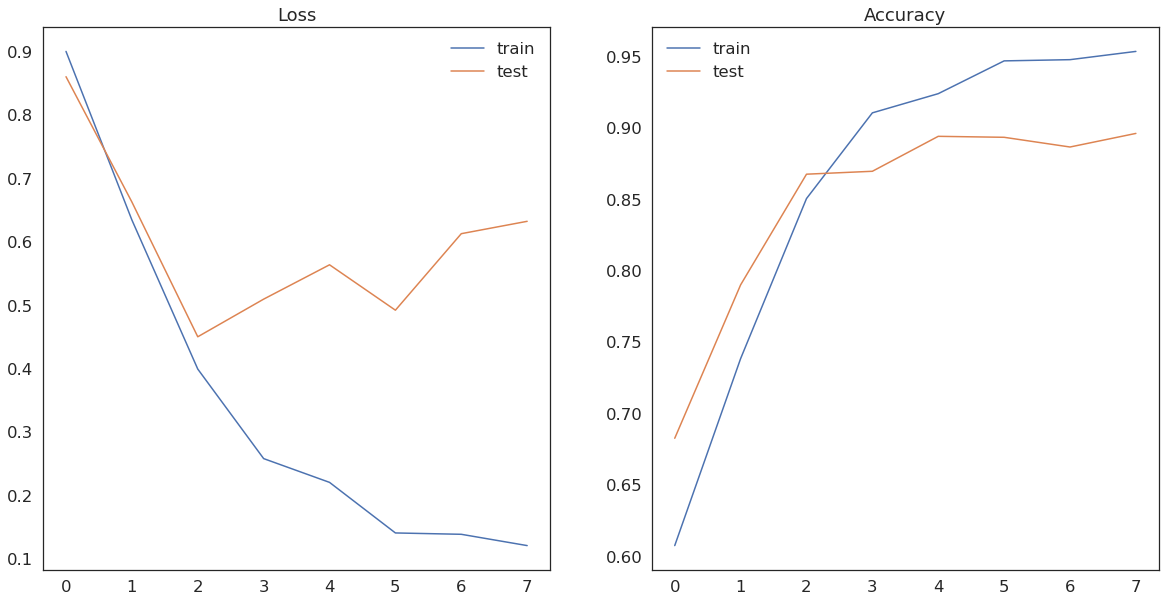

In [12]:
classifier1=run(model1)

In [13]:
from tensorflow.keras.models import Model


feature_extractor_model = Model(inputs=classifier1.input, outputs=classifier1.layers[0].output)
lstm_features = feature_extractor_model.predict(X_test)
print(lstm_features.shape)

(2947, 64)


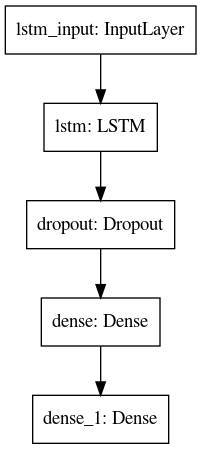

In [14]:
from tensorflow.keras.utils import plot_model
plot_model(classifier1, to_file = 'classifier1.png')

In [15]:
classifier1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                18944     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 390       
Total params: 23,494
Trainable params: 23,494
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Final evaluation of the model
scores = classifier1.evaluate(X_test, y_test, verbose=0)
print("Test Loss: %f" % (scores[0]))
print("Test Accuracy: %f%%" % (scores[1]*100))

Test Loss: 0.295374
Test Accuracy: 91.313201%


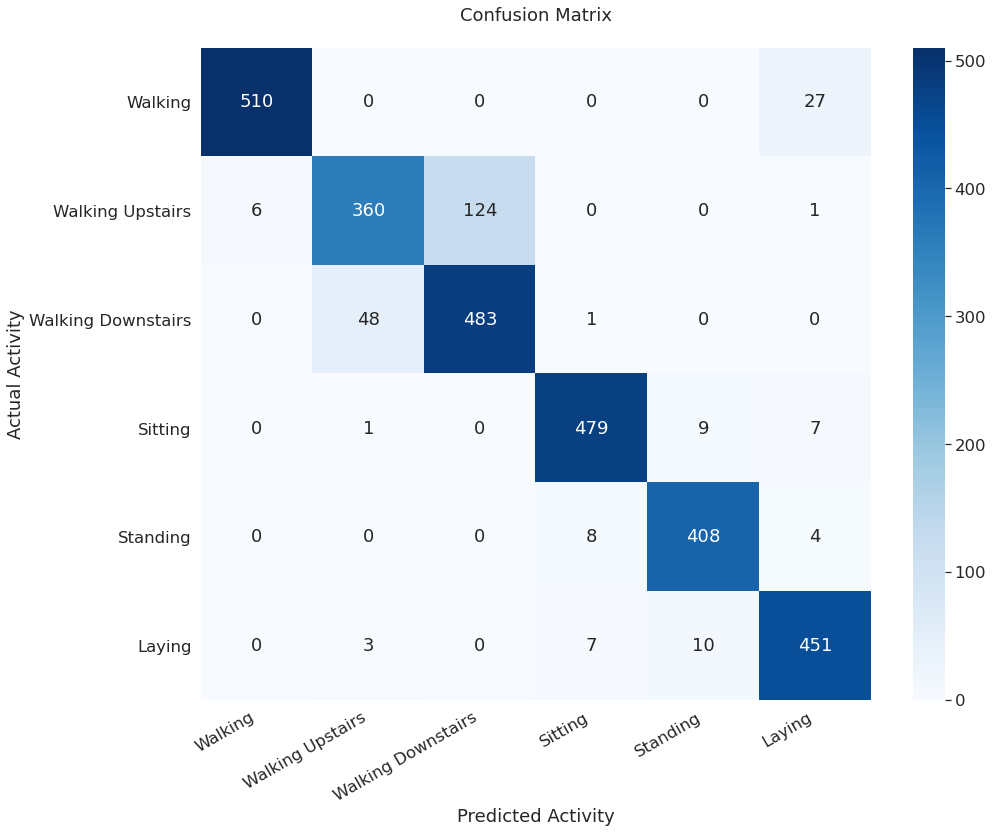

In [17]:
# Confusion Matrix
y_pred=classifier1.predict(X_test)
y_predict=pd.Series([activities[i+1] for i in np.argmax(y_pred, axis=1)])
y_actual=pd.Series([activities[i+1] for i in np.argmax(y_test, axis=1)])


# Code for drawing seaborn heatmaps
class_names = list(activities.values())
df_heatmap = pd.DataFrame(confusion_matrix(y_actual, y_predict) )
conf_matrix = confusion_matrix(y_actual, y_predict)
plt.style.use('seaborn-whitegrid')
sns.set(style="white", font_scale = 1.5)

fig = plt.figure(figsize=(15,12))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d", cmap="Blues")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=30, ha='right')
heatmap.set_xticklabels(class_names)
heatmap.set_yticklabels(class_names)
plt.ylabel('Actual Activity')
plt.xlabel('Predicted Activity')
plt.title("Confusion Matrix\n")

plt.show()


In [18]:
import numpy as np
from sklearn.metrics import confusion_matrix

def type1_and_type2_error(conf_matrix):
    """
    Compute Type I and Type II errors for each class given a confusion matrix.
    
    Parameters:
    - conf_matrix : numpy.ndarray
        The confusion matrix.
    
    Returns:
    - FPR : numpy.ndarray
        Type I error rates (False Positive Rate) for each class.
    - FNR : numpy.ndarray
        Type II error rates (False Negative Rate) for each class.
    """
    # Number of False Positives for each class
    FP = conf_matrix.sum(axis=0) - np.diag(conf_matrix)
    
    # Number of False Negatives for each class
    FN = conf_matrix.sum(axis=1) - np.diag(conf_matrix)
    
    # Number of True Positives for each class
    TP = np.diag(conf_matrix)
    
    # Number of True Negatives for each class
    TN = conf_matrix.sum() - (FP + FN + TP)
    
    # Convert to float to avoid integer division
    FP = FP.astype(float)
    FN = FN.astype(float)
    TP = TP.astype(float)
    TN = TN.astype(float)

    # Calculate Type I error (False Positive Rate) for each class
    FPR = FP / (FP + TN)
    
    # Calculate Type II error (False Negative Rate) for each class
    FNR = FN / (TP + FN)
    
    return FPR, FNR

type1_error, type2_error = type1_and_type2_error(conf_matrix)

# These arrays now hold the Type I and Type II error rates for each class
print("Type I Error Rates:", type1_error*100)
print("Type II Error Rates:", type2_error*100)

Type I Error Rates: [0.24896266 2.11726384 5.13457557 0.65279478 0.7518797  1.57512116]
Type II Error Rates: [ 5.02793296 26.6802444   9.21052632  3.42741935  2.85714286  4.2462845 ]


In [19]:
# Classification Report
cr=classification_report(y_actual, y_predict, target_names=activities.values(), digits=4)
print(cr)

                    precision    recall  f1-score   support

           Walking     0.9884    0.9497    0.9687       537
  Walking Upstairs     0.8738    0.7332    0.7973       491
Walking Downstairs     0.7957    0.9079    0.8481       532
           Sitting     0.9677    0.9657    0.9667       496
          Standing     0.9555    0.9714    0.9634       420
            Laying     0.9204    0.9575    0.9386       471

          accuracy                         0.9131      2947
         macro avg     0.9169    0.9143    0.9138      2947
      weighted avg     0.9155    0.9131    0.9125      2947



### CNN Model

In [20]:
def model2():
    seed(17)
    set_seed(17)
    K.clear_session()
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu',input_shape=(n_timesteps, n_features)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.7s
/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   30.2s finished


Epoch 1/10
736/736 - 3s - loss: 0.3259 - accuracy: 0.8669 - val_loss: 0.3467 - val_accuracy: 0.8933
Epoch 2/10
736/736 - 2s - loss: 0.1346 - accuracy: 0.9468 - val_loss: 0.2925 - val_accuracy: 0.8994
Epoch 3/10
736/736 - 2s - loss: 0.1089 - accuracy: 0.9512 - val_loss: 0.3008 - val_accuracy: 0.8756
Epoch 4/10
736/736 - 2s - loss: 0.1170 - accuracy: 0.9558 - val_loss: 0.4383 - val_accuracy: 0.8980
Epoch 5/10
736/736 - 2s - loss: 0.1100 - accuracy: 0.9526 - val_loss: 0.3224 - val_accuracy: 0.8878
Epoch 6/10
736/736 - 2s - loss: 0.0805 - accuracy: 0.9629 - val_loss: 0.3732 - val_accuracy: 0.9055
Epoch 7/10
736/736 - 2s - loss: 0.0943 - accuracy: 0.9582 - val_loss: 0.5013 - val_accuracy: 0.9109
Epoch 8/10
736/736 - 2s - loss: 0.1007 - accuracy: 0.9585 - val_loss: 0.5267 - val_accuracy: 0.8878
Epoch 9/10
736/736 - 2s - loss: 0.0786 - accuracy: 0.9638 - val_loss: 0.5379 - val_accuracy: 0.9028
Epoch 10/10
736/736 - 2s - loss: 0.0815 - accuracy: 0.9628 - val_loss: 0.6601 - val_accuracy: 0.8933

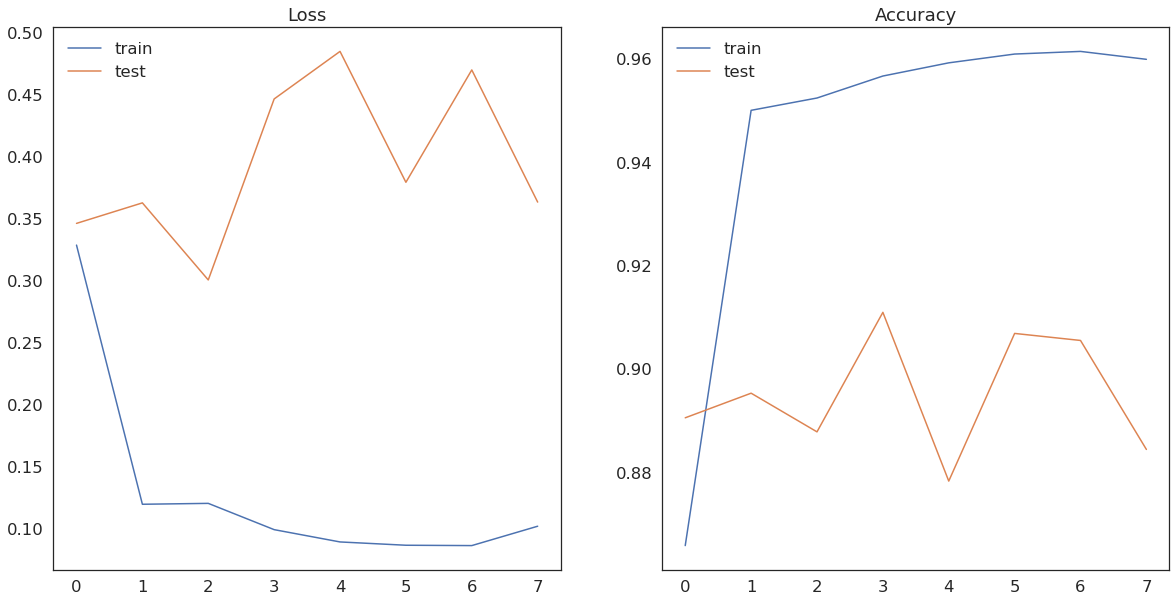

In [21]:
classifier2=run(model2)

In [22]:
from tensorflow.keras.models import Model


feature_extractor_model = Model(inputs=classifier2.input, outputs=classifier2.layers[0].output)
cnn_features = feature_extractor_model.predict(X_test)
print(cnn_features.shape)


(2947, 126, 64)


In [23]:
classifier2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 126, 64)           1792      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 124, 64)           12352     
_________________________________________________________________
dropout (Dropout)            (None, 124, 64)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 62, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 3968)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               396900    
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 6

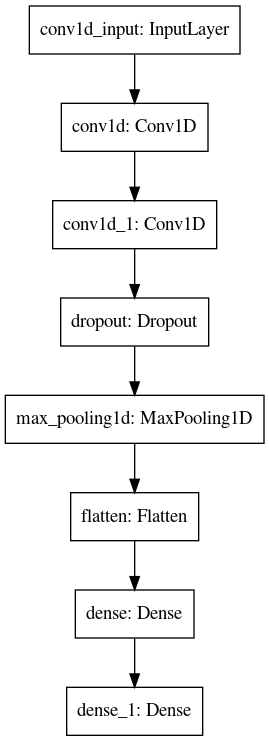

In [24]:
from tensorflow.keras.utils import plot_model
plot_model(classifier2, to_file = 'classifier1.png')

In [25]:
# Final evaluation of the model
scores = classifier2.evaluate(X_test, y_test, verbose=0)
print("Test Loss: %f" % (scores[0]))
print("Test Accuracy: %f%%" % (scores[1]*100))

Test Loss: 0.380284
Test Accuracy: 91.347134%


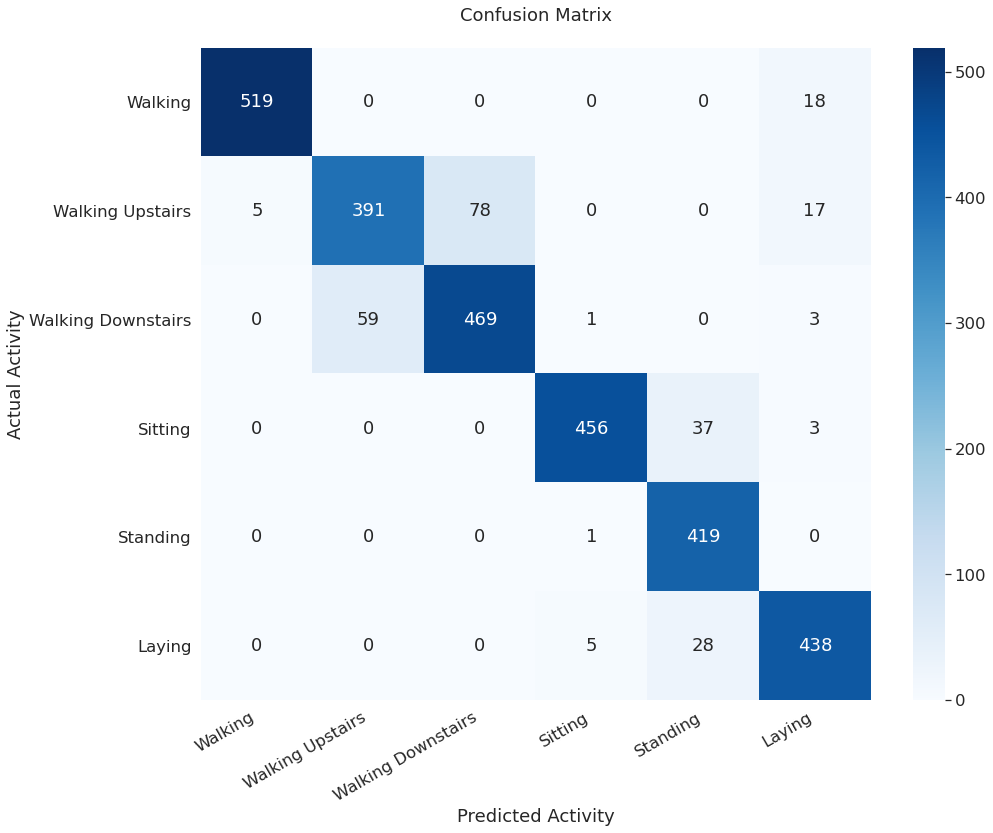

In [26]:
# Confusion Matrix
y_pred=classifier2.predict(X_test)
y_predict=pd.Series([activities[i+1] for i in np.argmax(y_pred, axis=1)])
y_actual=pd.Series([activities[i+1] for i in np.argmax(y_test, axis=1)])


# Code for drawing seaborn heatmaps
class_names = list(activities.values())
conf_matrix = confusion_matrix(y_actual, y_predict);
df_heatmap = pd.DataFrame(confusion_matrix(y_actual, y_predict) )

plt.style.use('seaborn-whitegrid')
sns.set(style="white", font_scale = 1.5)

fig = plt.figure(figsize=(15,12))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d", cmap="Blues")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=30, ha='right')
heatmap.set_xticklabels(class_names)
heatmap.set_yticklabels(class_names)
plt.ylabel('Actual Activity')
plt.xlabel('Predicted Activity')
plt.title("Confusion Matrix\n")

plt.show()

In [27]:
import numpy as np
from sklearn.metrics import confusion_matrix

def type1_and_type2_error(conf_matrix):
    """
    Compute Type I and Type II errors for each class given a confusion matrix.
    
    Parameters:
    - conf_matrix : numpy.ndarray
        The confusion matrix.
    
    Returns:
    - FPR : numpy.ndarray
        Type I error rates (False Positive Rate) for each class.
    - FNR : numpy.ndarray
        Type II error rates (False Negative Rate) for each class.
    """
    # Number of False Positives for each class
    FP = conf_matrix.sum(axis=0) - np.diag(conf_matrix)
    
    # Number of False Negatives for each class
    FN = conf_matrix.sum(axis=1) - np.diag(conf_matrix)
    
    # Number of True Positives for each class
    TP = np.diag(conf_matrix)
    
    # Number of True Negatives for each class
    TN = conf_matrix.sum() - (FP + FN + TP)
    
    # Convert to float to avoid integer division
    FP = FP.astype(float)
    FN = FN.astype(float)
    TP = TP.astype(float)
    TN = TN.astype(float)

    # Calculate Type I error (False Positive Rate) for each class
    FPR = FP / (FP + TN)
    
    # Calculate Type II error (False Negative Rate) for each class
    FNR = FN / (TP + FN)
    
    return FPR, FNR

type1_error, type2_error = type1_and_type2_error(conf_matrix)

# These arrays now hold the Type I and Type II error rates for each class
print("Type I Error Rates:", type1_error*100)
print("Type II Error Rates:", type2_error*100)

Type I Error Rates: [0.20746888 2.40228013 3.22981366 0.28559772 2.57222002 1.65589661]
Type II Error Rates: [ 3.35195531 20.36659878 11.84210526  8.06451613  0.23809524  7.00636943]


In [28]:
# Classification Report
cr=classification_report(y_actual, y_predict, target_names=activities.values(), digits=4)
print(cr)

                    precision    recall  f1-score   support

           Walking     0.9905    0.9665    0.9783       537
  Walking Upstairs     0.8689    0.7963    0.8310       491
Walking Downstairs     0.8574    0.8816    0.8693       532
           Sitting     0.9849    0.9194    0.9510       496
          Standing     0.8657    0.9976    0.9270       420
            Laying     0.9144    0.9299    0.9221       471

          accuracy                         0.9135      2947
         macro avg     0.9136    0.9152    0.9131      2947
      weighted avg     0.9153    0.9135    0.9132      2947



### CNN-LSTM Network Model

In [29]:
# reshape data into time steps of sub-sequences
n_steps, n_length = 4, 32
X_train = X_train.reshape((X_train.shape[0], n_steps, n_length, n_features))
X_test = X_test.reshape((X_test.shape[0], n_steps, n_length, n_features))

In [30]:
def model3():
    seed(17)
    set_seed(17)
    K.clear_session()
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Dropout(0.5)))
    model.add(TimeDistributed(Conv1D(filters=128, kernel_size=3, activation='relu')))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Dropout(0.5)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(100))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   54.6s finished


Epoch 1/10
736/736 - 4s - loss: 0.5574 - accuracy: 0.7635 - val_loss: 0.4966 - val_accuracy: 0.8865
Epoch 2/10
736/736 - 3s - loss: 0.2071 - accuracy: 0.9220 - val_loss: 0.3540 - val_accuracy: 0.9089
Epoch 3/10
736/736 - 3s - loss: 0.1479 - accuracy: 0.9405 - val_loss: 0.3911 - val_accuracy: 0.9089
Epoch 4/10
736/736 - 3s - loss: 0.1267 - accuracy: 0.9473 - val_loss: 0.4382 - val_accuracy: 0.9116
Epoch 5/10
736/736 - 3s - loss: 0.1159 - accuracy: 0.9478 - val_loss: 0.3778 - val_accuracy: 0.9116
Epoch 6/10
736/736 - 3s - loss: 0.1058 - accuracy: 0.9507 - val_loss: 0.3454 - val_accuracy: 0.9123
Epoch 7/10
736/736 - 3s - loss: 0.1126 - accuracy: 0.9515 - val_loss: 0.5278 - val_accuracy: 0.9055
Epoch 8/10
736/736 - 3s - loss: 0.1022 - accuracy: 0.9546 - val_loss: 0.3594 - val_accuracy: 0.9137
Epoch 9/10
736/736 - 3s - loss: 0.0905 - accuracy: 0.9583 - val_loss: 0.4034 - val_accuracy: 0.9232
Epoch 10/10
736/736 - 3s - loss: 0.0934 - accuracy: 0.9580 - val_loss: 0.4587 - val_accuracy: 0.9130

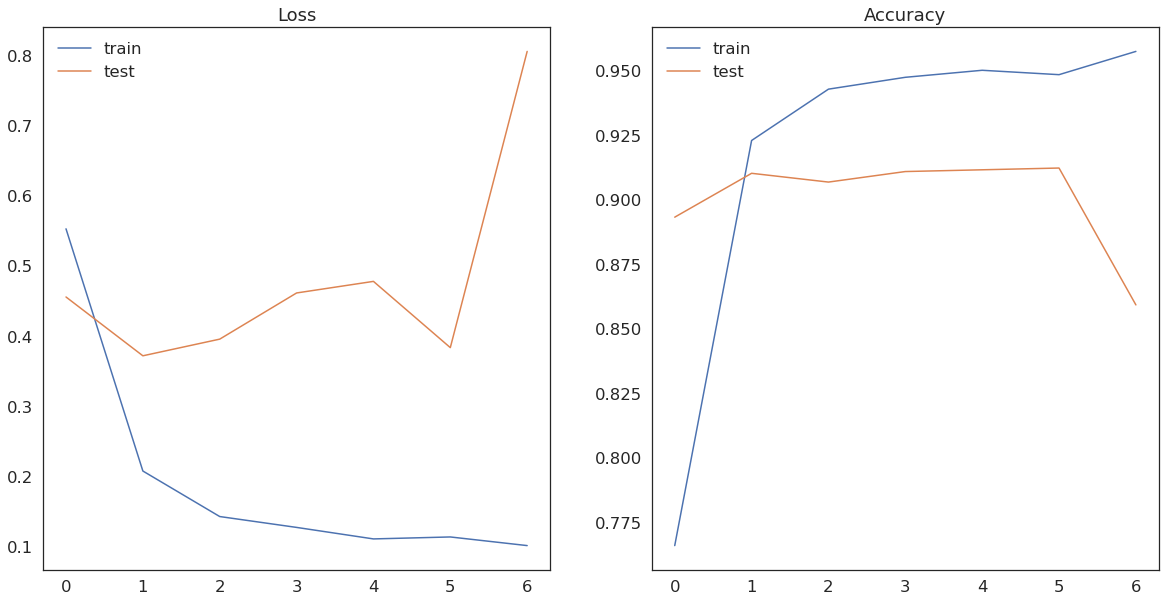

In [31]:
classifier3=run(model3)

In [32]:
from tensorflow.keras.models import Model


feature_extractor_model = Model(inputs=classifier3.input, outputs=classifier3.layers[0].output)
cnn_lstm_features = feature_extractor_model.predict(X_test)



In [33]:
cnn_lstm_features.shape

(2947, 4, 30, 64)

## Performance of Final Model

In [34]:
classifier3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 30, 64)      1792      
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 15, 64)      0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 15, 64)      0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 13, 128)     24704     
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 6, 128)      0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 6, 128)      0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, None, 768)         0

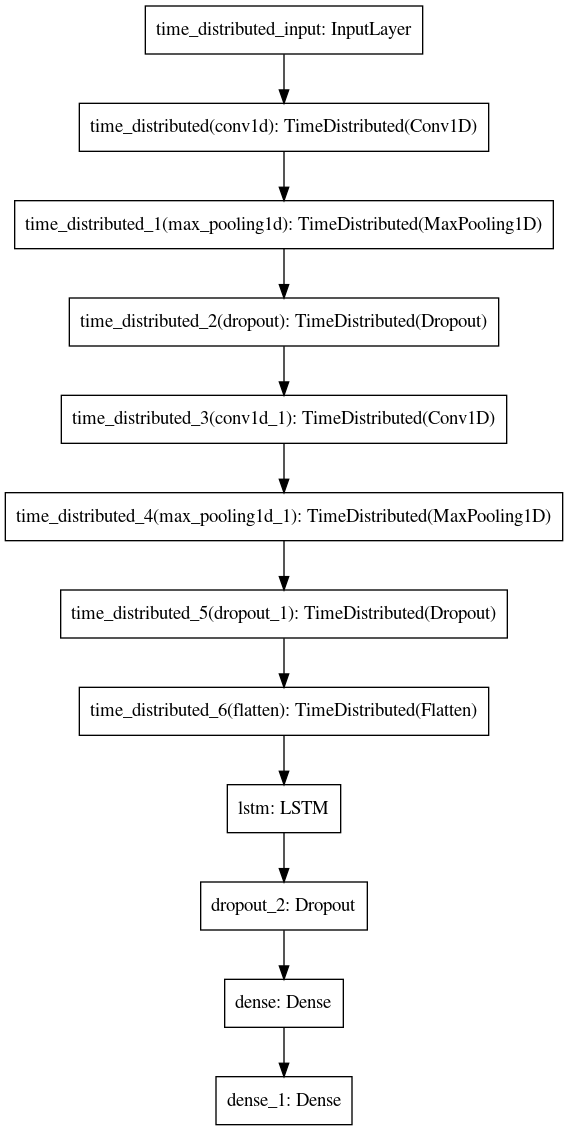

In [35]:
from tensorflow.keras.utils import plot_model
plot_model(classifier3, to_file = 'classifier1.png')

In [36]:
# Final evaluation of the model
scores = classifier3.evaluate(X_test, y_test, verbose=0)
print("Test Loss: %f" % (scores[0]))
print("Test Accuracy: %f%%" % (scores[1]*100))

Test Loss: 0.711221
Test Accuracy: 85.205293%


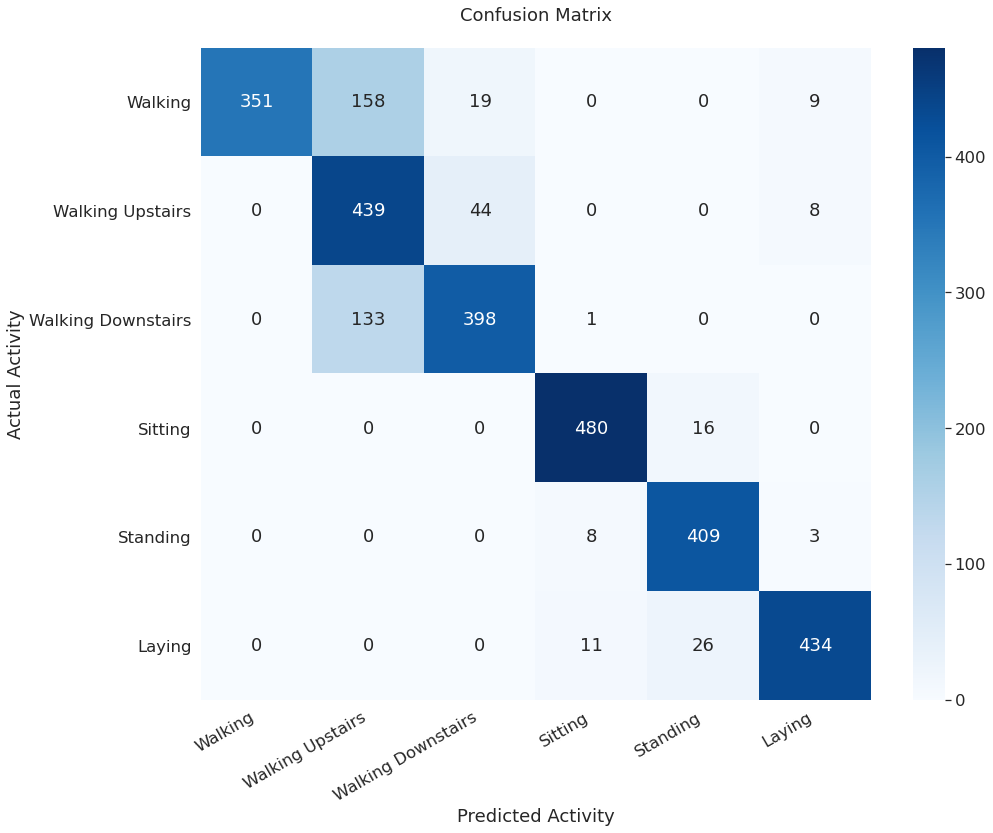

In [37]:
# Confusion Matrix
y_pred=classifier3.predict(X_test)
y_predict=pd.Series([activities[i+1] for i in np.argmax(y_pred, axis=1)])
y_actual=pd.Series([activities[i+1] for i in np.argmax(y_test, axis=1)])


# Code for drawing seaborn heatmaps
class_names = list(activities.values())
conf_matrix = confusion_matrix(y_actual, y_predict);
df_heatmap = pd.DataFrame(confusion_matrix(y_actual, y_predict) )

plt.style.use('seaborn-whitegrid')
sns.set(style="white", font_scale = 1.5)

fig = plt.figure(figsize=(15,12))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d", cmap="Blues")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=30, ha='right')
heatmap.set_xticklabels(class_names)
heatmap.set_yticklabels(class_names)
plt.ylabel('Actual Activity')
plt.xlabel('Predicted Activity')
plt.title("Confusion Matrix\n")

plt.show()

In [38]:
import numpy as np
from sklearn.metrics import confusion_matrix

def type1_and_type2_error(conf_matrix):
    """
    Compute Type I and Type II errors for each class given a confusion matrix.
    
    Parameters:
    - conf_matrix : numpy.ndarray
        The confusion matrix.
    
    Returns:
    - FPR : numpy.ndarray
        Type I error rates (False Positive Rate) for each class.
    - FNR : numpy.ndarray
        Type II error rates (False Negative Rate) for each class.
    """
    # Number of False Positives for each class
    FP = conf_matrix.sum(axis=0) - np.diag(conf_matrix)
    
    # Number of False Negatives for each class
    FN = conf_matrix.sum(axis=1) - np.diag(conf_matrix)
    
    # Number of True Positives for each class
    TP = np.diag(conf_matrix)
    
    # Number of True Negatives for each class
    TN = conf_matrix.sum() - (FP + FN + TP)
    
    # Convert to float to avoid integer division
    FP = FP.astype(float)
    FN = FN.astype(float)
    TP = TP.astype(float)
    TN = TN.astype(float)

    # Calculate Type I error (False Positive Rate) for each class
    FPR = FP / (FP + TN)
    
    # Calculate Type II error (False Negative Rate) for each class
    FNR = FN / (TP + FN)
    
    return FPR, FNR

type1_error, type2_error = type1_and_type2_error(conf_matrix)

# These arrays now hold the Type I and Type II error rates for each class
print("Type I Error Rates:", type1_error*100)
print("Type II Error Rates:", type2_error*100)

Type I Error Rates: [ 0.         11.8485342   2.60869565  0.81599347  1.66204986  0.80775444]
Type II Error Rates: [34.63687151 10.59063136 25.18796992  3.22580645  2.61904762  7.85562633]


In [39]:
# Classification Report
cr=classification_report(y_actual, y_predict, target_names=activities.values(), digits=4)
print(cr)

                    precision    recall  f1-score   support

           Walking     1.0000    0.6536    0.7905       537
  Walking Upstairs     0.6014    0.8941    0.7191       491
Walking Downstairs     0.8633    0.7481    0.8016       532
           Sitting     0.9600    0.9677    0.9639       496
          Standing     0.9069    0.9738    0.9392       420
            Laying     0.9559    0.9214    0.9384       471

          accuracy                         0.8521      2947
         macro avg     0.8813    0.8598    0.8588      2947
      weighted avg     0.8819    0.8521    0.8546      2947



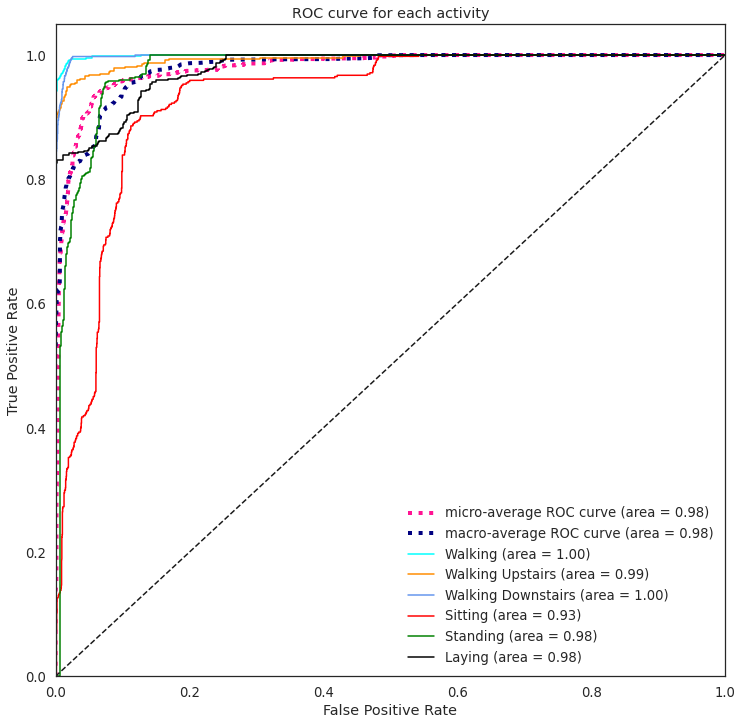

In [40]:
# ROC AUC
n_classes = 6

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
#Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.style.use('seaborn-whitegrid')
sns.set(style="white", font_scale = 1.2)
plt.figure(figsize=(12,12))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = ['aqua', 'darkorange', 'cornflowerblue', "red", "green", "black"]
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='{0} (area = {1:0.2f})'
             ''.format(activities[i+1], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for each activity')
plt.legend(loc="lower right")

plt.show()